## ML for Asset Management - Marcos Lopez de Prado 

**Date:** 2025-05-29

### Section 7 - Portfolio Construction

Markowitz proposed in 1952 a way of structring a portfolio to balance risk and reward: as a convex optimization problem. 

Markowitz’s Critical Line Algorithm (CLA) estimates an “efficient frontier” of portfolios that maximize the expected return subject to a given level of risk, where portfolio risk is measured in terms of the standard deviation of returns.

However, in practice, these "mean-variance optimal solutions" tend to be concentrated and unstable. 

**Improving:** There are three popular approaches to reducing the instability in optimal portfolios:

1. Regularize the solution by injecting more info regarding the mean and variance in the form of priors.

2. Reducing the feasibility region by incorporating additional constraints. 

3. Improving the numerical stability of the covariance matrix's inverse. 

In Chapter 2, we discussed how to deal with instability caused by *noise*, but turns out the signal contained in the covariance matrix can also be a source of instability which requires special treatment. 

In this chapter, we explain why certain data structures and types of signal can make mean-variance solutions unstable and what we can do to address this

### 7.2 Convex Portfolio Optimization:

Consider a portfolio of N holdings, where its returns (in excess of risk-free rate) have an expected value $\mu$ and expected covariance $V$. 

Markowitz's insight was to formulate the classical asset allocation problem as a quadratic program: $$\min_{\omega} \frac{1}{2} \omega^{'} V \omega$$

such that $\omega^{'}a = 1$ where $a$ characterizes the portfolio's constraints.

This problem can be expressed in Lagrangian form as:

$$L[\omega, \lambda] = \frac{1}{2} \omega^{'} V \omega - \lambda ( \omega^{'} a - 1 )$$

The first term is the objective (portfolio variance) and the second term enforces the constraint via $\lambda$

To find the optimal solution, take derivatives and set to zero, which gives:

1. Gradient w.r.t $\omega:$

$$
\frac{\partial L}{\partial \omega} = V \omega - \lambda a = 0 
\Rightarrow \omega = \lambda V^{-1} a
$$

2. Gradient w.r.t $\lambda:$
$$
\frac{\partial L}{\partial \lambda} = \omega^{'} a - 1 = 0 
\Rightarrow \lambda = 1 / (a' V^{-1} a)
$$

Thus:

$$w^{*} = \frac{V^{-1} a}{a' V^{-1} a}$$

Note that the second-order condition (Hessian) confirms that this solution is the minimum of the lagrangian:

$$
\begin{vmatrix}
\frac{\partial^2 L}{\partial \omega^2} & \frac{\partial^2 L}{\partial \omega \partial \lambda} \\
\frac{\partial^2 L}{\partial \lambda \partial \omega} & \frac{\partial^2 L}{\partial \lambda^2}
\end{vmatrix}
=
\begin{vmatrix}
V & -a \\
a^\top & 0
\end{vmatrix}
$$

This determinant simplifies to:
$$
\det
\begin{pmatrix}
V & -a \\
a^\top & 0
\end{pmatrix}
= a^\top a \geq 0
$$

Let's now turn to a few different formulations of the characteristic vector, a:

1. For $a = 1_N$ and $V = \sigma I_N$, then the solution solution is the equal weights portfolio (also known as the 1/N or naive portfolio) as $\omega_{*} = 1_N / N$
2. For $a = 1_N$ and V is a diagonal matrix with unequal entries, then the solution is the inverse-variance portfolio.
3. For $a = 1_N$ the solution is the minimum variance portfolio. 
4. For $a = \mu$, the solution maximises the portfolio's Sharpe ratio.

### 7.3 The Condition Number

Certain covariance structures can make the mean-variance optimization solution unstable. 

To understand why, we need to introduce the concept of **condition number** of a covariance matrix.

Consider a correlation matrix between two securities:
$$
C = 
\begin{bmatrix}
1 & \rho \\
\rho & 1
\end{bmatrix}
$$

Where $\rho$ is the correlation between their returns. 

Matrix C can be diagonalized as $C = W \Lambda W'$ or $CW = W \Lambda $ as follows. 

First we set the eigenvalue equation $|C-I\lambda| = 0$, which gives us roots $\lambda = 1 \pm \rho$. This gives us the diagonal elements of $\Lambda$. 

Second, the eigen vector associated with each eigenvalue is given by the solution to the system:

$$
\begin{bmatrix}
1 - \Lambda_{1,1} & \rho \\
\rho & 1 - \Lambda_{2,2}
\end{bmatrix}

\begin{bmatrix}
W_{1,1} & W_{1,2} \\
W_{2,1} & W_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
0 & 0 \\
0 & 0
\end{bmatrix}
$$

If C is not a diagonal matrix, then \rho \neq 0, which has solutions in:
$$
\begin{bmatrix}
W_{1,1} & W_{1,2} \\
W_{2,1} & W_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
\frac{1}{\sqrt2} & \frac{1}{\sqrt2} \\
\frac{1}{\sqrt2} & -\frac{1}{\sqrt2}
\end{bmatrix}
$$

and we can easily verify that:
$$

W \Lambda W'
=
\begin{bmatrix}
\frac{1}{\sqrt2} & \frac{1}{\sqrt2} \\
\frac{1}{\sqrt2} & -\frac{1}{\sqrt2}
\end{bmatrix}

\begin{bmatrix}
1+\rho & 0 \\
0 & 1-\rho
\end{bmatrix}

\begin{bmatrix}
\frac{1}{\sqrt2} & \frac{1}{\sqrt2} \\
\frac{1}{\sqrt2} & -\frac{1}{\sqrt2}
\end{bmatrix}
= C
$$


The trace of C is $tr(C) = \Lambda_{1,1} + \Lambda_{2,2} = 2$. The determinant of C is given by $1 - \rho^2$. This reaches its maximum when $\rho = 0$. The determinant reaches its minimum at $\Lambda_{1,1} = 0$ or $\Lambda_{2,2} = 0$, which corresponds to the perfectly correlated case, $|\rho| = 1$.

The inverse is C is:

$$C^{-1} = W \Lambda^{-1} W' = \frac{1}{|C|}\begin{bmatrix}
1 & -\rho \\
-\rho & 1
\end{bmatrix}$$

The implication is that the more $\rho$ deviates from zero, the bigger one eigenvalue becomes relative to the other, causing |C| to approach zero, which makes the values of $C_{-1}$ explode. 

More generally, the instability caused by covariance structure can be measured in terms of the magnitude between the two extreme eigenvalues. 

The condition number of a covariance or correlation matrix is defined as: the absolute value of the ratio between its maximal and minimal eigenvalues. 

### 7.4 Markowitz's Curse

Matrix C is just a standardized version of V, and thus the conclusions we drew on $C^{-1}$ apply to $V_{-1}$ which was used to compute $\omega^{*}$. 

When securities within a portfolio are highly correlated, C has a high condition number and the values of $V_{-1}$ explode.

This is problematic as since this affects $\omega^{*}$, we must expect an unstable solution to the convex optimization program. 

In other words, Markowitz's solution is guaranteed to be stable only if $\rho \approx 0$, but the reason we needed Markowitz was to handle the $\rho \not\approx 0$ case!

An earlier textbook introduced an ML-based assot allocation method called Hierarchical Risk Parity (HRP). This wasnt meant to be optimal, but just to demonstrate the potential of ML approaches. 

In the next section, we analyze further why standard mean-variance optimization is relatively easy to beat. 

### 7.5 Signal as a Source for Covariance Instability

In earlier sections, we saw how **noise-induced instability** in the covariance matrix depends on the ratio $ N/T $, where:

- $ N $: number of assets  
- $ T $: number of observations

This affects the **Marčenko–Pastur bounds**:

- Lower bound $ \lambda_- $ decreases as $ N/T $ increases  
- Upper bound $ \lambda_+ $ increases as $ N/T $ increases

However, in this section, we focus on a **different source of instability**: the **structure of the signal itself** — specifically, the correlation patterns between assets.

#### Signal-Induced Instability:

Even with perfect, noiseless data, instability can arise when **assets cluster** — that is, subsets of assets are more correlated with each other than with the rest.

Key points:

- The **identity correlation matrix** has condition number = 1  
- Introducing block structure (clusters) **increases the condition number**  
- The instability caused by signal is **structural** — it **cannot be reduced by increasing sample size**

#### Eigenvalue imbalance:

When K assets form a cluster:

- They load heavily on a **common eigenvector**
- That eigenvector's **eigenvalue grows**, but the **trace of the correlation matrix stays fixed** at N
- So, the variance explained by other $ K - 1 $ eigenvectors decreases
- Result: the **condition number increases**

This instability is **unrelated to** the $( N/T \to 1 )$ limit — it stems from **correlation structure**, not sample size.

Seen below:

The correlation matrix is $( 4 \times 4 )$, composed of two $( 2 \times 2 )$ blocks, each with an intrablock correlation of 0.5.

Key observations:

- Condition number ≠ 1 (it’s 3)
- Increasing one block’s size to 3 (and the other to 1) raises the condition number to 4
- Increasing the intrablock correlation to 0.75 pushes the condition number to 7

Condition number (max eigenvalue / min eigenvalue): 3.0


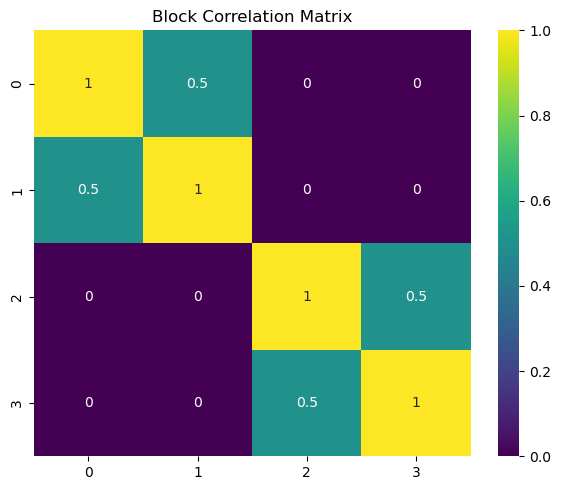

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import block_diag

# From Ch2:
from MLdP_utils import formBlockMatrix

# ---------------------------------------------------
# Generate block correlation matrix
corr0 = formBlockMatrix(2, 2, 0.5)

# Eigen decomposition
eVal, eVec = np.linalg.eigh(corr0)
print("Condition number (max eigenvalue / min eigenvalue):", max(eVal) / min(eVal))

# Plot correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr0, cmap='viridis', annot=True)
plt.title("Block Correlation Matrix")
plt.tight_layout()
plt.show()


In a larger $( 500 \times 500 )$ matrix with two blocks (each of size 250) and 0.5 correlation, the condition number becomes 251 — this demonstrates **how quickly signal structure creates instability** at scale.

#### Dominant clusters drive instability

Lowering correlation in one cluster **does not reduce** the condition number if the dominant cluster remains intact.  

Why?

- The **largest and most correlated block dominates the extreme eigenvalues**
- That **eigenvalue imbalance affects the whole matrix**

In [3]:
# Show that if we bring down the intrablock correlation 
# in only one of the two block, the condition number is not reduced

corr0=block_diag(formBlockMatrix(1,2,.5))
corr1=formBlockMatrix(1,2,.0)
corr0=block_diag(corr0,corr1)

eVal , eVec = np.linalg.eigh(corr0)

print("Condition number (max eigenvalue / min eigenvalue):", max(eVal) / min(eVal))

Condition number (max eigenvalue / min eigenvalue): 3.0


The **instability of Markowitz’s solution** is often due to **a few dominant clusters** in the correlation matrix
- This suggests a practical solution:

**Optimize dominant clusters separately** to prevent instability from contaminating the entire portfolio

This lays the foundation for **modular or hierarchical optimization techniques** in portfolio construction.

### 7.6 The Nested Clustered Optimization Algorithm

The rest of the chapter is dedicated to introducing a new ML-based method, names nester clustered optimization (NCO), which tackles the source of Markowitz's curse. 

NCO provides a strategy for addressing the effect of Markowitz's curse on an existing mean-variance allocation method.

#### 7.6.1 Correlation clustering

The first step is to cluster the correlation matrix, which involves finding the optimal number of clusters. We can use the ONC algorithm for this. For large matrices, where T/N is relatively low, it is advisable to denoise the correlation matrix prior to clustering (see chapter 2).

The following code implements this:
- Compute the denoise covariance matrix cov1, where q informs the ratio between the number of rows to columns in the observation matrix. 
- Standardize the resulting covariance matrix into a correlation matrix
- Cluster the cleaned correlation matrix 

(The argument maxNumClusters is set to half the number of columns in the correlation matrix. The reason is, single-item clusters do not cause an increase in the matrix’s condition number, only need to consider clusters with a minimum size of two)

Note: A common question is whether we should cluster corr1 or corr1.abs(). When some correlations are negative, the answer depends on the numerical properties of the observed inputs. Soln: try both and see what clustering works better for your particular corr1 in Monte Carlo experiments.

Implemented Below:

In [63]:
# Data Generation:
import pandas as pd
from MLdP_utils import formTrueMatrix, simCovMu

# Start with true
mu_true, cov_true = formTrueMatrix(nBlocks=4, bSize=10, bCorr=0.5)

nObs=1000

mu0, cov0 = simCovMu(mu_true, cov_true, nObs, shrink=False)

# Recast cov0 as DataFrame with proper index/columns
cols = cov_true.columns  # use true matrix's structure
cov0 = pd.DataFrame(cov0, index=cols, columns=cols)

T = nObs  # number of historical observations (assumed days we observed it)
N = cov0.shape[0]  # number of assets
q = T / N


In [64]:
# Correlation Clustering:

# Old functions from Ch 2 and Ch 4.
from MLdP_utils import deNoiseCov, cov2corr, clusterKMeansBase

# Preserve original column names
cols = cov0.columns

# Step 1: De-noise the covariance matrix
cov1 = deNoiseCov(cov0, q, bWidth=0.01)
cov1 = pd.DataFrame(cov1, index=cols, columns=cols)

# Step 2: Convert the de-noised covariance matrix to a correlation matrix
corr1 = cov2corr(cov1)

# Step 3: Apply KMeans clustering to the de-noised correlation matrix
corr1, clstrs, silh = clusterKMeansBase(
    corr1,
    maxNumClusters=corr0.shape[0] // 2,  # limit number of clusters to half the number of assets
    n_init=10  # number of random initializations for stability
)


Number of clusters found: 4


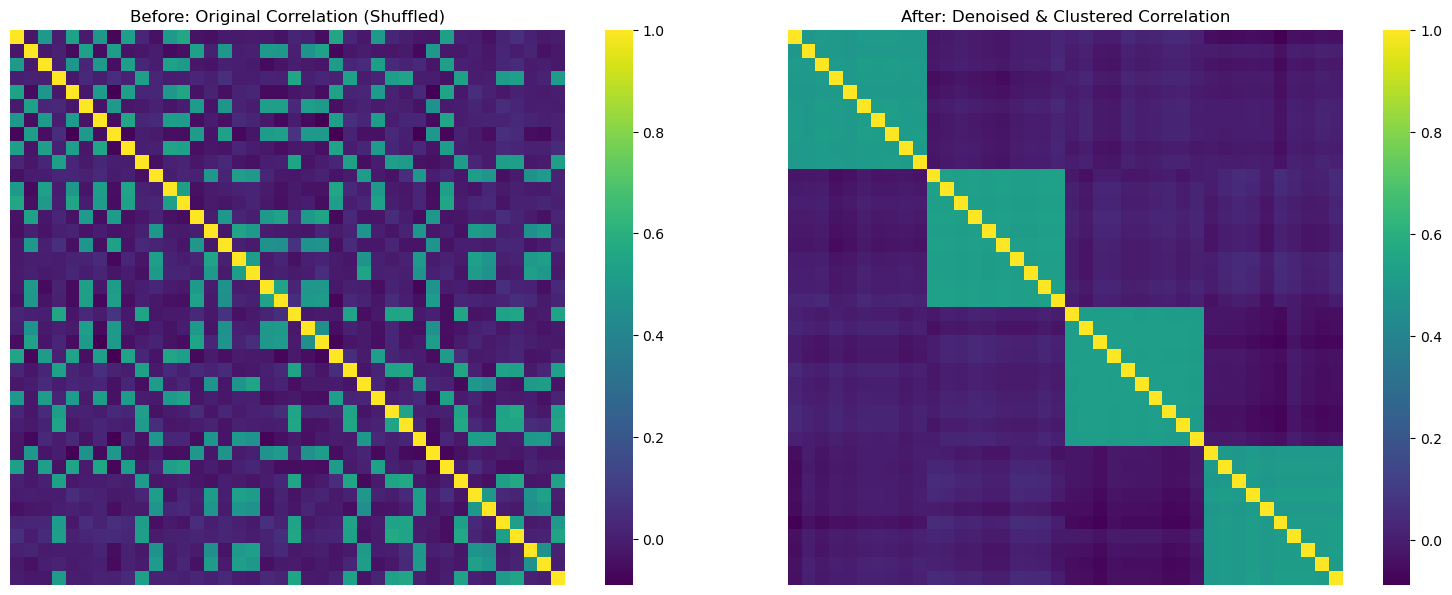

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

num_clusters = len(clstrs)
print(f"Number of clusters found: {num_clusters}")

# Convert original covariance matrix to correlation
corr0 = cov2corr(cov0)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original shuffled correlation matrix
sns.heatmap(corr0, cmap="viridis", square=True, ax=axes[0],
            xticklabels=False, yticklabels=False)
axes[0].set_title("Before: Original Correlation (Shuffled)")

# Reordered and denoised correlation matrix
sns.heatmap(corr1, cmap="viridis", square=True, ax=axes[1],
            xticklabels=False, yticklabels=False)
axes[1].set_title("After: Denoised & Clustered Correlation")

plt.tight_layout()
plt.show()


#### Intracluster Weights

The second step of the NCO algorithm is to compute optimal intracluster allocations, using the denoised covariance matrix, cov1.

Note: For simplicity purposes, we have defaulted to a minimum variance allocation, as implemented in the minVarPort function. However, nothing in the procedure prevents the use of alternative allocation methods. 

Using the estimated intracluster weights, we can derive the reduced covariance matrix, cov2, which reports the correlations between clusters.

In [66]:
# Intracluster Weights:

import numpy as np

def minVarPort(cov):
    """
    Compute minimum variance portfolio weights.

    Parameters
    ----------
    cov : pd.DataFrame or np.ndarray
        Covariance matrix of asset returns.

    Returns
    -------
    np.ndarray
        Optimal weights that minimize portfolio variance.
    """
    cov = np.array(cov)
    inv_cov = np.linalg.pinv(cov)  # Use pseudo-inverse for numerical stability
    ones = np.ones(cov.shape[0])
    w = inv_cov @ ones
    w /= ones.T @ inv_cov @ ones
    return w.reshape(-1, 1)

#Create a DataFrame of size [assets × clusters]:
wIntra = pd.DataFrame(0.0, index=cov1.index, columns=clstrs.keys())

#Each column will store the weights of assets in that cluster, and 0 elsewhere.

for i in clstrs:
    # Compute minimum variance portfolio weights for each cluster
    weights = minVarPort(cov1.loc[clstrs[i], clstrs[i]]).flatten()
    wIntra.loc[clstrs[i], i] = weights

# Compute reduced covariance matrix using intracluster weights
cov2 = wIntra.T @ cov1 @ wIntra

# This compresses the full covariance matrix down into a cluster-level covariance matrix.
# Now we're modeling how the optimized clusters co-move.
# Cov2 is of size [clusters × clusters], which is much smaller than the original [assets × assets].


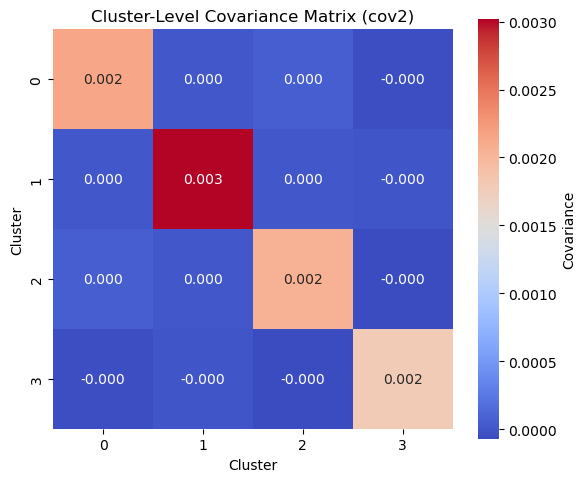

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cov2, annot=True, cmap='coolwarm', fmt=".3f", square=True,
            cbar_kws={'label': 'Covariance'})
plt.title("Cluster-Level Covariance Matrix (cov2)")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


#### Intercluster Weights:

The third step of the NCO algorithm is to compute optimal intercluster allocations, using the reduced covariance matrix, cov2.

By construction, this covariance matrix is close to a diagonal matrix, and the optimization problem is close to the ideal Markowitz case. In other words, the clustering and intracluster optimization steps have allowed us to transform a “Markowitz-cursed” problem $\rho >> 0$ into a well-behaved problem $\rho \approx 0$.

The following code implements this:

In [68]:
# Compute inter-cluster weights: weights assigned to each cluster
wInter = pd.Series(
    minVarPort(cov2).flatten(),
    index=cov2.index
)

#Each element in wInter tells you: "How much to allocate to the portfolio representing cluster i"

# Combine intra-cluster and inter-cluster weights to get final portfolio weights
# For each asset, multiply its weight within the cluster by the cluster's total weight
wAll0 = wIntra.mul(wInter, axis=1).sum(axis=1).sort_index()

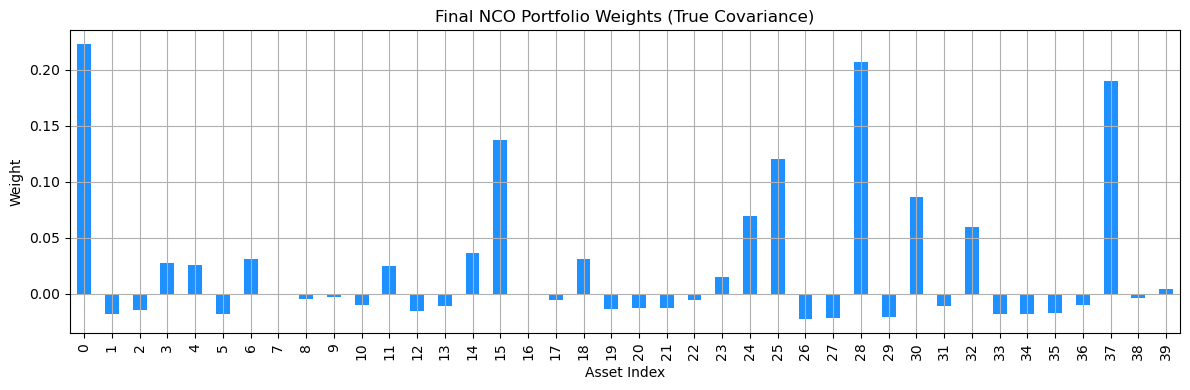

In [69]:
import matplotlib.pyplot as plt

wAll0.plot(kind="bar", figsize=(12, 4), color="dodgerblue")
plt.title("Final NCO Portfolio Weights (True Covariance)")
plt.xlabel("Asset Index")
plt.ylabel("Weight")
plt.tight_layout()
plt.grid(True)
plt.show()


In [70]:
# Now compare to the global minimum variance portfolio weights:

from MLdP_utils import optPort

w_gmv = pd.Series(optPort(cov1).flatten(), index=cov1.index).sort_index()

### 7.6 Experimental results:

The following code implements the NCO algorithm. 

When argument mu is None, function optPort_nco returns the minimum variance portfolio, whereas when mu is not None, function optPort_nco returns the maximum Sharpe ratio portfolio.

In [74]:
from MLdP_utils import optPort, cov2corr, clusterKMeansBase

def optPort_nco(cov, mu=None, maxNumClusters=None):
    """
    Computes the Nested Clustered Optimization (NCO) portfolio weights.

    Parameters:
    - cov: Covariance matrix (DataFrame)
    - mu: Expected returns (optional, as np.ndarray or pd.Series)
    - maxNumClusters: Maximum number of clusters for k-means clustering

    Returns:
    - nco: Optimal portfolio weights (as a column vector)
    """
    cov = pd.DataFrame(cov)

    if mu is not None:
        mu = pd.Series(mu[:, 0])

    # Step 1: Correlation clustering
    corr1 = cov2corr(cov)
    corr1, clstrs, _ = clusterKMeansBase(corr1, maxNumClusters=maxNumClusters, n_init=10)

    # Step 2: Intra-cluster optimization
    wIntra = pd.DataFrame(0.0, index=cov.index, columns=clstrs.keys())
    for i in clstrs:
        cov_ = cov.loc[clstrs[i], clstrs[i]].values
        if mu is None:
            mu_ = None
        else:
            mu_ = mu.loc[clstrs[i]].values.reshape(-1, 1)

        wIntra.loc[clstrs[i], i] = optPort(cov_, mu_).flatten()

    # Step 3: Inter-cluster optimization
    cov_ = wIntra.T @ cov.values @ wIntra
    mu_ = None if mu is None else wIntra.T @ mu.values.reshape(-1, 1)
    wInter = pd.Series(optPort(cov_, mu_).flatten(), index=cov_.index)

    # Step 4: Combine weights
    nco = wIntra.mul(wInter, axis=1).sum(axis=1).values.reshape(-1, 1)
    
    return nco


In [78]:
# Using NCO:

from MLdP_utils import formTrueMatrix, simCovMu, deNoiseCov, optPort
import pandas as pd

# 1. Generate true covariance + means
mu_true, cov_true = formTrueMatrix(nBlocks=4, bSize=10, bCorr=0.5)

# 2. Simulate observed sample
mu_sim, cov_sim = simCovMu(mu_true, cov_true, nObs=1000, shrink=False)
cov_sim = pd.DataFrame(cov_sim, index=cov_true.index, columns=cov_true.columns)

# 3. Denoise
q = 1000 / cov_sim.shape[0]
cov_dn = deNoiseCov(cov_sim, q, bWidth=0.01)
cov_dn = pd.DataFrame(cov_dn, index=cov_sim.index, columns=cov_sim.columns)

# 4. Compute NCO portfolio
w_nco = optPort_nco(cov_dn, mu=None, maxNumClusters=10)


### 7.8 Conclusion:
### Tackling Instability in Portfolio Optimization: The NCO Approach

While Markowitz’s mean-variance framework is mathematically elegant, its real-world application often struggles with **numerical instability**. The root cause lies in the **inversion of noisy covariance matrices**—a step that can greatly magnify estimation errors. As a result, even small changes in input data can lead to wildly different portfolio allocations and elevated transaction costs that eat away at returns.

---

#### The Problem: Condition Numbers & Clustering

In finance, asset returns tend to exhibit **clustered correlation structures**—certain groups of securities move together more closely than others. This clustering inflates the **condition number** of the correlation matrix and causes the **eigenvalue spectrum** to become skewed. When the eigenvalues are uneven (non-horizontal), Markowitz optimization becomes unstable. 

> This type of instability is **structural**, driven by **signal**, and cannot be corrected by simply collecting more data.

---

#### The Solution: Nested Clustered Optimization (NCO)

The **NCO algorithm** addresses this problem by breaking the optimization into two levels:

1. **Intra-cluster optimization**  
   Each cluster of highly correlated assets is optimized separately to form a mini-portfolio with minimum variance.

2. **Inter-cluster optimization**  
   These mini-portfolios are then combined into a global portfolio, using another round of optimization.

The final portfolio weights are the **product of intra- and inter-cluster weights**.

---

#### Why NCO Works

- Reduces exposure to unstable eigenvectors
- Contains instability within local clusters
- Improves **estimation robustness** and **portfolio turnover**

And crucially, **NCO is modular**:
- It can integrate with shrinkage methods, Black–Litterman, constrained optimization, and even hierarchical models (clusters within clusters).

---

#### Practical Insights

Using **Monte Carlo simulations**, we can compare the **allocation errors** of traditional vs. NCO-based methods under realistic conditions. This helps identify which method performs best in a given setting, turning portfolio construction into a **data-driven, adaptive process**.

Rather than committing to a single optimization model, practitioners can now choose the method that’s most robust for their specific data—and NCO provides the flexibility to do exactly that.


### Todo:

Run the Monte Carlo Simulations and go through exercises